In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

from Utilities.utils import (
    analyze_graph_dataset,
    build_graph_data,
    convert_nx_to_pyg,
    convert_nx_to_pyg_2,
    generate_new_fully_connected_graph,
    visualize_graph,
)

from Utilities.model import (
    GraphGenerator,
    train_model,
    test_model,
    negative_sampling
)

c:\Users\baoqt\miniconda3\envs\311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Data Loading ---
with open('Dataset\Graphs2.JSON', 'r') as file:
    graph_data = json.load(file)

# --- Analyze and Filter Dataset ---
type_counts, type_encodings, graph_data = analyze_graph_dataset(graph_data)
type_reverse_encodings = {idx: name for name, idx in type_encodings.items()}

print("Node type counts:", type_counts)
print("Node type to index mapping:", type_encodings)
print("Filtered graph data:", graph_data)

Node type counts: defaultdict(<class 'int'>, {'Circulation': 99, 'Bed': 183, 'Living': 100, 'Bath': 107})
Node type to index mapping: {'Bed': 0, 'Bath': 1, 'Living': 2, 'Circulation': 3}
Filtered graph data: [{'Graph': {'Properties': {'NodeCount': 5, 'EdgeCount': 4, 'Type': 'unset', 'FullyConnected': True, 'GGUID': '9cc96741-1947-40e3-a0b7-59e509b61d7d'}, 'Attributes': {'Width': 8.029813545769926, 'Length': 8.312131408747348}, 'Nodes': [{'Properties': {'Id': 'N0', 'Type': 'Circulation', 'Point': {'X': 3.963, 'Y': 2.401, 'Z': 0.0}, 'Valence': 1, 'IsInGraph': True, 'GGUID': 'a03d0171-5d41-477f-8566-3f31a5ff6070', 'IsNaked': True, 'Angle': 'null'}, 'Attributes': {}, 'Point': {'X': 3.963, 'Y': 2.401, 'Z': 0.0}}, {'Properties': {'Id': 'N1', 'Type': 'Bed', 'Point': {'X': 1.5645, 'Y': 1.568, 'Z': 0.0}, 'Valence': 2, 'IsInGraph': True, 'GGUID': '69aedf11-2686-4795-b8a8-78bdda1f01e6', 'IsNaked': False, 'Angle': 16.837458717551296}, 'Attributes': {}, 'Point': {'X': 1.5645, 'Y': 1.568, 'Z': 0.0}}

Graph count: 80
Visualizing graph #40


e:\Documents\GitHub\GenAIExample\Graph\Utilities\utils.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


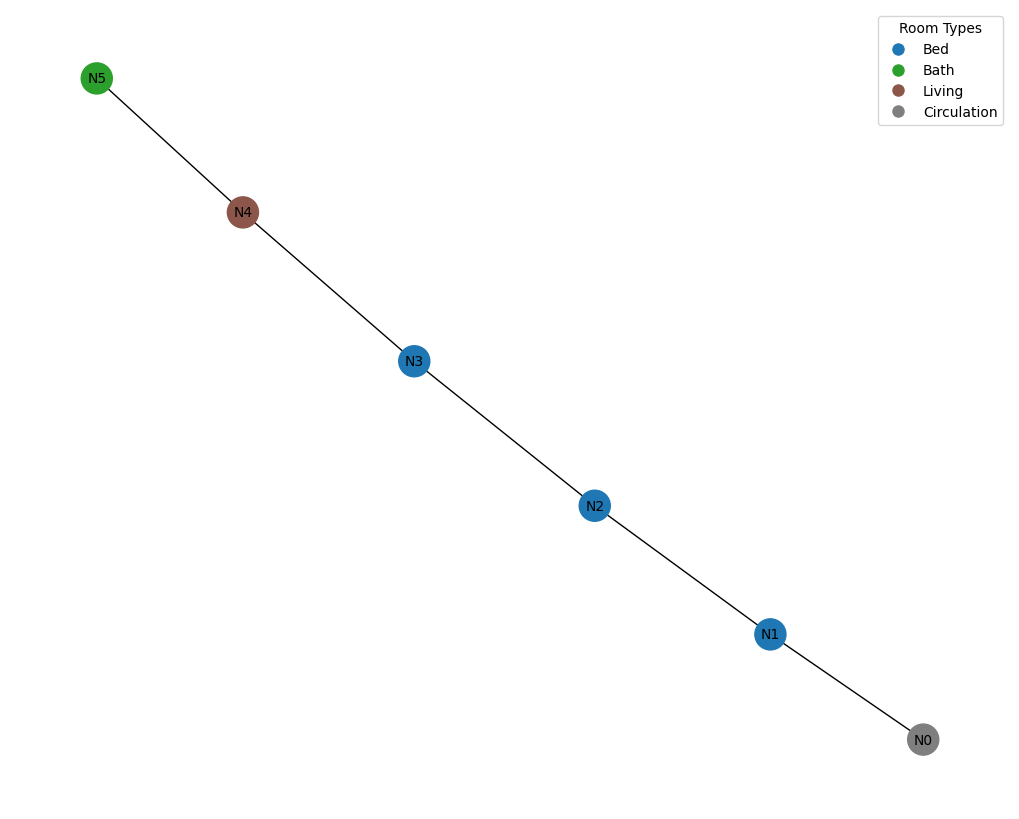

In [3]:
# --- Process Graphs (using reusable function) ---
nx_train_graphs, nx_test_graphs = build_graph_data(graph_data, type_encodings)

print("Graph count:", len(nx_train_graphs))

# Visualize a random graph from the list
random_index = random.randint(0, len(nx_train_graphs) - 1)
print(f"Visualizing graph #{random_index}")
visualize_graph(nx_train_graphs[random_index], type_encodings)

In [4]:
# --- Convert to PyG Data ---
pyg_train_graphs = []
for i, graph in enumerate(nx_train_graphs):
    data_obj = convert_nx_to_pyg(graph, type_encodings)
    if data_obj is not None:
        pyg_train_graphs.append(data_obj)

pyg_test_graphs = []
for i, graph in enumerate(nx_test_graphs):
    data_obj = convert_nx_to_pyg(graph, type_encodings)
    if data_obj is not None:
        pyg_test_graphs.append(data_obj)

print(f"Converted {len(pyg_train_graphs)} graphs to PyTorch Geometric Data objects.")

# Print the shape of an example tensor from the PyG graphs
if len(pyg_train_graphs) > 0:
    print("Example tensor shape:", pyg_train_graphs[0].x.shape)
    
    # Print the node feature tensor
    print("Node feature tensor:")
    print(pyg_train_graphs[0].x)
    
    # Also print edge_index tensor
    print("Edge index tensor:")
    print(pyg_train_graphs[0].edge_index)
    print("Edge index tensor shape:", pyg_train_graphs[0].edge_index.shape)
    
    # Print edge labels
    print("Edge labels:")
    print(pyg_train_graphs[0].edge_labels)
else:
    print("No PyG graphs available.")

Converted 80 graphs to PyTorch Geometric Data objects.
Example tensor shape: torch.Size([5, 15])
Node feature tensor:
tensor([[  0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   4.0175,   2.4980,
          11.4354,  10.1915, 116.5436,   2.0000,   1.0000,   1.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   4.6875,   7.5935,
          11.4354,  10.1915, 116.5436,   2.0000,   1.0000,   1.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.7515,   7.0935,
          11.4354,  10.1915, 116.5436,   2.0000,   1.0000,   1.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   8.6535,   5.0955,
          11.4354,  10.1915, 116.5436,   2.0000,   1.0000,   1.0000,   1.0000,
           0.0000],
        [  0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0815,   1.9980,
          11.4354,  10.1915, 116.5436,   2.0000,   1.0000,   1.0000,   1.0000,
           0

In [5]:
# --- Model Setup ---
hidden_dim = 64
model = GraphGenerator(node_features=pyg_train_graphs[0].x.shape[1], hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

print("Model summary:")
print(model)

Model summary:
GraphGenerator(
  (conv1): GATConv(15, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 64, heads=1)
  (node_predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=15, bias=True)
  )
  (edge_predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [6]:
# --- Training ---
num_epochs = 500
batch_size = 32

train_loader = DataLoader(pyg_train_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(pyg_test_graphs, batch_size=batch_size, shuffle=False)

# Train the model
train_model(model, train_loader, optimizer, criterion, num_epochs)

c:\Users\baoqt\miniconda3\envs\311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


ValueError: Using a target size (torch.Size([480])) that is different to the input size (torch.Size([360])) is deprecated. Please ensure they have the same size.

In [ ]:
# Evaluate the model on the test set
test_model(model, test_loader, criterion, device='cpu')

Test Loss: 0.5530, Accuracy: 85.06%, Total Correct: 262, Total Samples: 308


In [ ]:
# Select a random graph from the test set
random_index = random.randint(0, len(nx_test_graphs) - 1)
random_graph = nx_test_graphs[random_index]
print(f"Testing on graph #{random_index}")

# Convert the selected graph to PyG format
pyg_graph = convert_nx_to_pyg(random_graph, type_encodings)

if pyg_graph is not None:
    # Create a DataLoader for the single graph
    single_graph_loader = DataLoader([pyg_graph], batch_size=1, shuffle=False)
    
    # Test the model on the single graph
    test_model(model, single_graph_loader, criterion, device='cpu')
else:
    print("Failed to convert the selected graph to PyG format.")

Testing on graph #5
Test Loss: 1.8012, Accuracy: 50.00%, Total Correct: 8, Total Samples: 16


In [ ]:
# # Select a random graph from the test set
# random_index = random.randint(0, len(nx_test_graphs) - 1)
# random_graph = nx_test_graphs[random_index]
# print(f"Testing on graph #{random_index}")

# # Convert the selected graph to PyG format
# pyg_graph = convert_nx_to_pyg(random_graph, type_encodings)

# if pyg_graph is not None:
#     # Create a DataLoader for the single graph
#     single_graph_loader = DataLoader([pyg_graph], batch_size=1, shuffle=False)
    
#     # Test the model on the single graph
#     model.eval()
#     with torch.no_grad():
#         for data in single_graph_loader:
#             data = data.to('cpu')
            
#             # Encode node features
#             z = model.encode(data.x, data.edge_index)
            
#             # Positive edges
#             pos_edge_index = data.edge_index
#             num_nodes = data.num_nodes
#             num_pos = pos_edge_index.size(1)
            
#             # Negative edges
#             neg_edge_index = negative_sampling(pos_edge_index, num_nodes, num_neg_samples=num_pos)
            
#             # Combine edges and labels
#             edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
#             edge_labels = torch.cat([
#                 torch.ones(num_pos, device='cpu'),   # Positive
#                 torch.zeros(num_pos, device='cpu')  # Negative
#             ])
            
#             # Predict edges
#             edge_pred = model.decode_edges(z, edge_index)
#             edge_pred = edge_pred.view(-1)  # Flatten to match labels
            
#             # Print details
#             print("Edge Index Tensor:")
#             print(edge_index)
#             print("Ground Truth (Edge Labels):")
#             print(edge_labels)
#             print("Predicted Edge Probabilities:")
#             print(edge_pred)
# else:
#     print("Failed to convert the selected graph to PyG format.")

Testing on graph #15
Edge Index Tensor:
tensor([[0, 1, 1, 2, 2, 3, 3, 0, 2, 3, 0, 1],
        [1, 0, 2, 1, 3, 2, 1, 3, 0, 0, 2, 3]])
Ground Truth (Edge Labels):
tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
Predicted Edge Probabilities:
tensor([0.9580, 0.9580, 0.9607, 0.9606, 0.9629, 0.9629, 0.9617, 0.9528, 0.9593,
        0.9604, 0.9569, 0.9594])


In [ ]:
# # --- Example: Generate and Visualize New Graph ---
# required_nodes = {
#     'Bed': 2,
#     'Living': 1,
#     'Bath': 1,
#     'Circulation': 1
# }
# apartment_width = 5.0
# apartment_length = 10.0
# num_additional_nodes = 0

# new_graph = generate_new_fully_connected_graph(
#     required_nodes=required_nodes,
#     apartment_width=apartment_width,
#     apartment_length=apartment_length,
#     num_additional_nodes=num_additional_nodes,
#     type_encodings=type_encodings,
#     type_reverse_encodings=type_reverse_encodings
# )

# visualize_graph(new_graph, type_encodings)

# # Convert the new graph to a PyG graph
# new_pyg_graph = convert_nx_to_pyg_2(new_graph, type_encodings)

# # Print the shape of an example tensor from the PyG graphs
# print("Example tensor shape:", new_pyg_graph.x.shape)

# # Print the node feature tensor
# print("Node feature tensor:")
# print(new_pyg_graph.x)

# # Also print edge_index tensor
# print("Edge index tensor:")
# print(new_pyg_graph.edge_index)
# print("Edge index tensor shape:", new_pyg_graph.edge_index.shape)


# # Print the result
# if new_pyg_graph is not None:
#     print("New PyG graph created successfully.")
#     print(new_pyg_graph)
# else:
#     print("Failed to convert the new graph to PyG format.")

# # Classify edges in the new PyG graph
# if new_pyg_graph is not None:
#     edge_classifications = classify_edges(model, new_pyg_graph, device='cpu')
#     print("Edge classifications:", edge_classifications)
# else:
#     print("New PyG graph is not available for edge classification.")